In [1]:
#Import necessary Libraries
import pandas as pd
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from varclushi import VarClusHi
from datetime import datetime
from operator import attrgetter
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import  GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from category_encoders import WOEEncoder

In [2]:
#Display settings 
display = pd.options.display
display.max_columns = 1000
display.max_rows = 1000
display.max_colwidth = 199
display.width = 1000

In [3]:
#Reading the csv file into a dataframe
loanData = pd.read_csv('/Users/vibhor/Desktop/Models/LC/Loan_status_2007-2020Q3.gzip', index_col=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
#Dimensions of the dataframe
loanData.shape

(2925493, 141)

In [5]:
loanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925493 entries, 0 to 105450
Columns: 141 entries, id to debt_settlement_flag
dtypes: float64(106), object(35)
memory usage: 3.1+ GB


In [6]:
#Retrieving the names of the columns in the datasets
print(list(loanData.columns))

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot

In [7]:
loanData.duplicated().sum() # no duplicates (takes time)

0

In [8]:
len(loanData.columns[loanData.isna().any()]) # Except the id column all others have N
#to print them
#loanData.columns[loanData.isna().any().tolist()


140

In [9]:
missing_data = loanData.isna().mean() #by variable this returns count(na)/total entries
#missing_data.plot.hist(bins=20)

In [10]:
drop_list = list(missing_data[missing_data > 0.2].index)
print("\n\n Drop Features: ", len(drop_list))
print(drop_list)



 Drop Features:  49
['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_a

In [11]:
df = loanData.copy(deep = True)

Copied from Arun

In [12]:
#Data cleanup
df['int_rate'] = df['int_rate'].str[:-1].astype(float) #Strip off the %sign
df['revol_util'] = df['revol_util'].str[:-1].astype(float) #Strip off the %sign

df['emp_length'].fillna(value=-1,inplace=True)
df['emp_length'].replace(to_replace='< 1 year', value='0', inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True,regex=True)
df['term'] = pd.to_numeric(df['term'].str.replace(' months', ''))

In [13]:
df['emp_length'].mode()

0    10
dtype: object

In [14]:
df['emp_length'].replace(to_replace = -1, value = '10', inplace=True)

In [15]:
df["issue_d"].mode()

0    Mar-2016
dtype: object

In [16]:
#Cannot run the strptime function without replacing NaNs
df['issue_d'].fillna(value = 'Mar-2016', inplace = True)

In [17]:
#Cleaning up the date variables and also creating a loan vintage variable
df['issue_date']  = df["issue_d"].apply(lambda x: datetime.strptime(x, "%b-%Y"))


In [18]:
#creating new vintage variable
df['vintage'] = pd.to_datetime(df['issue_date']).dt.year

In [19]:
df['earliest_cr_line'].mode()

0    Sep-2005
dtype: object

In [20]:
df['earliest_cr_line'].fillna(value = 'Sep-2005', inplace = True) 

In [21]:
#Creating a new variable for length of history at loan issue
df['oldest_credit_date']  = df["earliest_cr_line"].apply(lambda x: datetime.strptime(x, "%b-%Y"))


df['credit_hist'] = (df.issue_date.dt.to_period('M') \
                                - df.oldest_credit_date.dt.to_period('M')).apply(attrgetter('n'))

#If the attribute getter is not applied we get month ends instead of int like values

In [22]:
#winsorizing dti to upper and lower 0.1 percentile limits
df['dti'] = winsorize(df['dti'], limits = (.001, 0.001)) 

#annual income has a 0 for some loans and that will create problems when creating pti and loan_to_inc variables 
#winsorizing annual income lower to 0.1 percentile limits

df['annual_inc'] = winsorize(df['annual_inc'], limits = (.002, 0)) 


In [23]:
df['annual_inc'].describe(percentiles = [0.0001, 0.0005, 0.001])

count    2.925488e+06
mean     7.994902e+04
std      1.117397e+05
min      8.184000e+03
0.01%    8.184000e+03
0.05%    8.184000e+03
0.1%     8.184000e+03
50%      6.600000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

In [24]:
#Funded Ratio - Hypothesis: If smaller fraction of loan gets funded that could point to a problem in obligor profile
df['fund_ratio'] = df['funded_amnt'].div(df['loan_amnt'])

#Loan to Income Ratio
df['loan_to_inc'] = df['funded_amnt'].div(df['annual_inc'])

#Monthly payment to income ratio
df['pti'] = (12 * df['installment']).div(df['annual_inc'])

Some of these variables in drop_list are important but they have just too many missing values to fill, thats why dropping them all

In [25]:
df.loc[:,drop_list].isna().sum()

mths_since_last_delinq                        1536503
mths_since_last_record                        2498045
next_pymnt_d                                  1860332
mths_since_last_major_derog                   2202576
annual_inc_joint                              2714980
dti_joint                                     2714984
verification_status_joint                     2730706
open_acc_6m                                    866131
open_act_il                                    866130
open_il_12m                                    866130
open_il_24m                                    866130
mths_since_rcnt_il                             926530
total_bal_il                                   866130
il_util                                       1157149
open_rv_12m                                    866130
open_rv_24m                                    866130
max_bal_bc                                     866130
all_util                                       866486
inq_fi                      

In [26]:
df['initial_list_status'].value_counts() #does most of what fund ratio does, so dropping that below

w    2139434
f     786058
Name: initial_list_status, dtype: int64

In [27]:
#### From Arun and judgment
other_vars_remove  = ['url','oldest_credit_date','earliest_cr_line','policy_code','zip_code', 'sec_app_fico_range_low',
                          'sec_app_fico_range_high','sec_app_earliest_cr_line','fico_range_low', 'fico_range_high',
                     'annual_inc_joint','dti_joint','verification_status_joint', 'revol_bal_joint','sec_app_inq_last_6mths',
                     'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il', 'issue_d', 'issue_date'
                      'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
                       'addr_state','title','sub_grade', 'fund_ratio', 'emp_title', 'id']   
                     


In [28]:
temporal_vars_remove = ['last_credit_pull_d','last_fico_range_high','last_fico_range_low','total_pymnt',
                        'total_pymnt_inv','recoveries','collection_recovery_fee','out_prncp','out_prncp_inv',
                        'total_rec_prncp','total_rec_int','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
                        'total_rec_late_fee','hardship_flag','hardship_amount',
                        'orig_projected_additional_accrued_interest','hardship_payoff_balance_amount',
                        'hardship_last_payment_amount','debt_settlement_flag','hardship_type','hardship_reason',
                        'hardship_status','deferral_term','hardship_start_date','hardship_end_date','payment_plan_start_date',
                        'hardship_length','hardship_dpd','hardship_loan_status','installment','pymnt_plan',
                        'acc_now_delinq']


In [ ]:
a_set = set(other_vars_remove)
b_set = set(temporal_vars_remove)
if (a_set & b_set):
    print(a_set & b_set)
else:
    print("No common elements") 

In [29]:
#use Venn Diagram. Set function is not needed as there wont be any repeats in the lists, but used for completeness
#In A but not in B or C + In B but not in C + C
vars_dropped = list(set(drop_list) - set(other_vars_remove) - set(temporal_vars_remove)) + \
list(set(other_vars_remove) - set(temporal_vars_remove)) + temporal_vars_remove
len(vars_dropped)

83

In [30]:
retained_variables = list(set(df.columns) - set(vars_dropped))
len(retained_variables)

66

In [31]:
print(retained_variables)

['term', 'total_bc_limit', 'mort_acc', 'num_rev_accts', 'num_il_tl', 'num_rev_tl_bal_gt_0', 'funded_amnt', 'num_actv_rev_tl', 'num_bc_sats', 'open_acc', 'emp_length', 'num_actv_bc_tl', 'num_bc_tl', 'verification_status', 'loan_amnt', 'loan_status', 'vintage', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_accts_ever_120_pd', 'total_bal_ex_mort', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'num_tl_op_past_12m', 'num_tl_120dpd_2m', 'home_ownership', 'mo_sin_rcnt_rev_tl_op', 'total_acc', 'bc_util', 'mo_sin_old_il_acct', 'purpose', 'revol_bal', 'tot_coll_amt', 'mo_sin_rcnt_tl', 'loan_to_inc', 'mths_since_recent_inq', 'application_type', 'tot_cur_bal', 'avg_cur_bal', 'revol_util', 'pti', 'num_op_rev_tl', 'pct_tl_nvr_dlq', 'annual_inc', 'delinq_2yrs', 'acc_open_past_24mths', 'grade', 'bc_open_to_buy', 'initial_list_status', 'percent_bc_gt_75', 'int_rate', 'total_il_high_credit_limit', 'mo_sin_old_rev_tl_op', 'funded_amnt_inv', 'issue_date', 'num_sats', 'dti', 'tot_hi_cred_lim', 'n

In [32]:
df_small = df.loc[:,retained_variables] #dataframe of retained variables. 

In [106]:
#target variable is loan_status. Understand what values it takes and its corresponding counts
loanData['loan_status'].value_counts()

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: loan_status, dtype: int64

In [33]:
#new COflag
keep_status = ['Charged Off', 'Fully Paid', 'Late (16-30 days)', 'Late (31-120 days)', 'Default', 'Current']


In [34]:
df_small = df_small[df_small['loan_status'].isin(keep_status)]

In [35]:
#create a chargeoff flag
df_small['coFlag'] = 1
df_small.loc[df_small['loan_status'].isin(['Fully Paid','Late (16-30 days)','Current']), 'coFlag'] = 0

In [36]:
temp_means = (df_small._get_numeric_data().mean())

In [37]:
df_small.drop(['loan_status'], axis = 1, inplace = True)

In [38]:
#counting number of object type (categorical) and numeric and getting a list of those
#Counter(df_refined.dtypes)
num_cols = df_small._get_numeric_data().columns
cat_cols = list(set(df_small.columns) - set(num_cols))

In [39]:
df_small.loc[:, cat_cols].isna().any() #Cat cols dont have missing values.

purpose                False
initial_list_status    False
issue_date             False
emp_length             False
application_type       False
home_ownership         False
verification_status    False
grade                  False
dtype: bool

In [40]:
df_num = df_small.loc[:, num_cols]

In [41]:
num_cols

Index(['term', 'total_bc_limit', 'mort_acc', 'num_rev_accts', 'num_il_tl', 'num_rev_tl_bal_gt_0', 'funded_amnt', 'num_actv_rev_tl', 'num_bc_sats', 'open_acc', 'num_actv_bc_tl', 'num_bc_tl', 'loan_amnt', 'vintage', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_accts_ever_120_pd', 'total_bal_ex_mort', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'num_tl_op_past_12m', 'num_tl_120dpd_2m', 'mo_sin_rcnt_rev_tl_op', 'total_acc', 'bc_util', 'mo_sin_old_il_acct', 'revol_bal', 'tot_coll_amt', 'mo_sin_rcnt_tl', 'loan_to_inc', 'mths_since_recent_inq', 'tot_cur_bal', 'avg_cur_bal', 'revol_util', 'pti', 'num_op_rev_tl', 'pct_tl_nvr_dlq', 'annual_inc', 'delinq_2yrs', 'acc_open_past_24mths', 'bc_open_to_buy', 'percent_bc_gt_75', 'int_rate', 'total_il_high_credit_limit', 'mo_sin_old_rev_tl_op', 'funded_amnt_inv', 'num_sats', 'dti', 'tot_hi_cred_lim', 'num_tl_90g_dpd_24m', 'mths_since_recent_bc', 'pub_rec', 'num_tl_30dpd', 'inq_last_6mths', 'tax_liens', 'total_rev_hi_lim', 'credit_hist',
    

In [42]:
cat_cols

['purpose',
 'initial_list_status',
 'issue_date',
 'emp_length',
 'application_type',
 'home_ownership',
 'verification_status',
 'grade']

In [ ]:
df_small['emp_length'].dtype

In [43]:
for var in num_cols:
    df_num[var].fillna(temp_means[var], inplace = True)   

In [44]:
df_num.isna().any()

term                          False
total_bc_limit                False
mort_acc                      False
num_rev_accts                 False
num_il_tl                     False
num_rev_tl_bal_gt_0           False
funded_amnt                   False
num_actv_rev_tl               False
num_bc_sats                   False
open_acc                      False
num_actv_bc_tl                False
num_bc_tl                     False
loan_amnt                     False
vintage                       False
chargeoff_within_12_mths      False
delinq_amnt                   False
num_accts_ever_120_pd         False
total_bal_ex_mort             False
collections_12_mths_ex_med    False
pub_rec_bankruptcies          False
num_tl_op_past_12m            False
num_tl_120dpd_2m              False
mo_sin_rcnt_rev_tl_op         False
total_acc                     False
bc_util                       False
mo_sin_old_il_acct            False
revol_bal                     False
tot_coll_amt                

In [45]:
df_cat = df_small.loc[:, cat_cols]

In [46]:
#making Purpose into a 3 category variable. 
main_purpose = ['home_improvement', 'other', 'major_purchase' , 'small_business', 'car', 'medical', \
               'moving', 'vacation', 'house', 'wedding', 'renewable_energy', 'educational']

df_cat['new_purpose'] = df_cat['purpose']


df_cat.loc[df_cat['purpose'].isin(main_purpose), 'new_purpose'] = 'other'


In [47]:
#making home_ownership into a 3 category variable. 
main_purpose = ['ANY', 'NONE', 'OTHER' , 'OWN']

df_cat['cat_home_ownership'] = df_cat['home_ownership']


df_cat.loc[df_cat['home_ownership'].isin(main_purpose), 'cat_home_ownership'] = 'OTHER'

In [48]:
df_cat.drop(['home_ownership', 'purpose'], axis = 1, inplace = True)

In [49]:
df_cat.columns

Index(['initial_list_status', 'issue_date', 'emp_length', 'application_type', 'verification_status', 'grade', 'new_purpose', 'cat_home_ownership'], dtype='object')

In [68]:
df_tempterm = df_num.pop('term')

In [70]:
df_cat_full = pd.concat([df_cat, df_tempterm], axis = 1)

In [84]:
df_cat_dummy = pd.get_dummies(df_cat_full, columns = ['application_type', 'verification_status', 'grade', 
                                                'initial_list_status', 'emp_length', 'new_purpose', 
                                                'cat_home_ownership', 'term'], drop_first = True)

In [73]:
df_Y = df_num.pop('coFlag')

In [95]:
sc = StandardScaler()
X_num_std = sc.fit_transform(df_num)

In [96]:
X_num_std = pd.DataFrame(X_num_std, columns = df_num.columns)

In [97]:
X_num_std.head()

,total_bc_limit,mort_acc,num_rev_accts,num_il_tl,num_rev_tl_bal_gt_0,funded_amnt,num_actv_rev_tl,num_bc_sats,open_acc,num_actv_bc_tl,num_bc_tl,loan_amnt,vintage,chargeoff_within_12_mths,delinq_amnt,num_accts_ever_120_pd,total_bal_ex_mort,collections_12_mths_ex_med,pub_rec_bankruptcies,num_tl_op_past_12m,num_tl_120dpd_2m,mo_sin_rcnt_rev_tl_op,total_acc,bc_util,mo_sin_old_il_acct,revol_bal,tot_coll_amt,mo_sin_rcnt_tl,loan_to_inc,mths_since_recent_inq,tot_cur_bal,avg_cur_bal,revol_util,pti,num_op_rev_tl,pct_tl_nvr_dlq,annual_inc,delinq_2yrs,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,int_rate,total_il_high_credit_limit,mo_sin_old_rev_tl_op,funded_amnt_inv,num_sats,dti,tot_hi_cred_lim,num_tl_90g_dpd_24m,mths_since_recent_bc,pub_rec,num_tl_30dpd,inq_last_6mths,tax_liens,total_rev_hi_lim,credit_hist
0,0.0,0.0,-2.239837e-16,0.0,0.0,-1.092630,0.0,2.891406e-16,-1.513753,0.0,-1.921033e-16,-1.092893,-2.664308,-0.078562,-0.015306,0.0,0.0,-0.119681,-0.347524,0.0,-1.874283e-17,0.0,-1.244275,2.579626e-13,-8.050326e-16,-0.144175,-3.828233e-18,0.0,-0.112485,4.765279e-16,0.0,3.305883e-16,1.395111,-0.011398,-3.775469e-16,-2.695116e-12,-0.500548,-0.343262,0.0,1.963405e-15,-3.390601e-13,-0.491383,0.0,0.0,-1.093781,0.0,0.532104,0.0,0.0,1.104130e-16,-0.336259,0.0,0.529286,-0.108839,0.0,1.366853
1,0.0,0.0,-2.239837e-16,0.0,0.0,-1.356508,0.0,2.891406e-16,-1.513753,0.0,-1.921033e-16,-1.356735,-2.664308,-0.078562,-0.015306,0.0,0.0,-0.119681,-0.347524,0.0,-1.874283e-17,0.0,-1.658419,2.579626e-13,-8.050326e-16,-0.666019,-3.828233e-18,0.0,-0.768896,4.765279e-16,0.0,3.305883e-16,-1.590792,-0.871982,-3.775469e-16,-2.695116e-12,-0.446851,-0.343262,0.0,1.963405e-15,-3.390601e-13,0.459225,0.0,0.0,-1.354976,0.0,-1.165224,0.0,0.0,1.104130e-16,-0.336259,0.0,5.244637,-0.108839,0.0,-0.478044
2,0.0,0.0,-2.239837e-16,0.0,0.0,-1.367063,0.0,2.891406e-16,-1.688209,0.0,-1.921033e-16,-1.367289,-2.664308,-0.078562,-0.015306,0.0,0.0,-0.119681,-0.347524,0.0,-1.874283e-17,0.0,-1.161447,2.579626e-13,-8.050326e-16,-0.610654,-3.828233e-18,0.0,-0.177848,4.765279e-16,0.0,3.305883e-16,1.989881,0.005969,-3.775469e-16,-2.695116e-12,-0.605688,-0.343262,0.0,1.963405e-15,-3.390601e-13,0.601199,0.0,0.0,-1.365529,0.0,-0.673541,0.0,0.0,1.104130e-16,-0.336259,0.0,1.708124,-0.108839,0.0,-0.812498
3,0.0,0.0,-2.239837e-16,0.0,0.0,-0.564872,0.0,2.891406e-16,-0.292562,0.0,-1.921033e-16,-0.565207,-2.664308,-0.078562,-0.015306,0.0,0.0,-0.119681,-0.347524,0.0,-1.874283e-17,0.0,1.074930,2.579626e-13,-8.050326e-16,-0.495387,-3.828233e-18,0.0,-0.139168,4.765279e-16,0.0,3.305883e-16,-1.124621,0.008409,-3.775469e-16,-2.695116e-12,-0.275019,-0.343262,0.0,1.963405e-15,-3.390601e-13,0.092973,0.0,0.0,-0.563478,0.0,0.044878,0.0,0.0,1.104130e-16,-0.336259,0.0,0.529286,-0.108839,0.0,-0.068067
4,0.0,0.0,-2.239837e-16,0.0,0.0,-1.303732,0.0,2.891406e-16,0.579717,0.0,-1.921033e-16,-1.303967,-2.664308,-0.078562,-0.015306,0.0,0.0,-0.119681,-0.347524,0.0,-1.874283e-17,0.0,1.157759,2.579626e-13,-8.050326e-16,0.472518,-3.828233e-18,0.0,-1.009580,4.765279e-16,0.0,3.305883e-16,0.197535,-1.077965,-3.775469e-16,-2.695116e-12,0.000627,-0.343262,0.0,1.963405e-15,-3.390601e-13,-0.071634,0.0,0.0,-1.302209,0.0,-0.086323,0.0,0.0,1.104130e-16,-0.336259,0.0,-0.649552,-0.108839,0.0,-0.057278


In [98]:
X_num_std.reset_index(inplace=True, drop=True)

In [100]:
df_Y.reset_index(inplace=True, drop=True)

In [101]:
df_cat_dummy.reset_index(inplace=True, drop=True)

In [102]:
df_model = pd.concat([df_Y, df_cat_dummy,X_num_std], axis = 1)

In [104]:
df_model.shape

(2910653, 83)

In [109]:
df_test_train = df_model[df_model.issue_date <= '2019-09-01']
holdOut = df_model[df_model.issue_date > '2019-09-01'] #Out of time holdout
trainSet, testSet = train_test_split(df_test_train, test_size = 0.3, random_state=693) #test and train splits

In [110]:
trainSet.drop(['issue_date'], axis = 1, inplace = True)
testSet.drop(['issue_date'], axis = 1, inplace = True)
holdOut.drop(['issue_date'], axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [111]:
df_Ytrain = trainSet.pop('coFlag')

In [112]:
df_Ytest = testSet.pop('coFlag')

In [113]:
df_YHO = holdOut.pop('coFlag')

In [114]:
df_Ytrain = df_Ytrain.to_frame()

In [115]:
df_Ytrain['coFlag'].value_counts()

0    1583739
1     263761
Name: coFlag, dtype: int64

In [65]:
263761/(263761 + 1583739)

0.14276644113667117

In [131]:
c = [10, 1, .1, 0.01, .001]
clf = LogisticRegression(penalty='l1',  C = c[4], class_weight = {0: .1427, 1: 0.8573}, solver='saga')
clf.fit(trainSet, df_Ytrain)
print('C:', c[4])
print('Coefficient of each feature:', clf.coef_)
print('Training accuracy:', clf.score(trainSet, df_Ytrain))
print('Test accuracy:', clf.score(testSet, df_Ytest))
print('')

/Users/vibhor/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vibhor/.local/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


C: 0.001
Coefficient of each feature: [[-0.03018499  0.05804349  0.07459951  0.          0.12858004  0.00679539
   0.          0.          0.          0.004286    0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.10927244
   0.13208782 -0.10297698 -0.0569874   0.         -0.00832662  0.
   0.03227644  0.04111853  0.03190083  0.          0.00291764  0.
   0.02541489 -0.30246402  0.          0.00198246  0.          0.
   0.01504289  0.          0.          0.         -0.00616099 -0.00192497
   0.         -0.02132433  0.          0.         -0.01083794  0.04353352
  -0.05696277  0.         -0.00054252  0.          0.02294894  0.
   0.         -0.0172201   0.04475483  0.18757451 -0.01475741  0.0381365
   0.45505312 -0.00337724 -0.00734986  0.0354425  -0.0349243   0.01559483
  -0.11843698  0.         -0.04022858  0.03823153  0.00107455  0.02535893
   0.          0.          0.00453615]]
Training 

In [132]:
importance = np.abs(clf.coef_)

In [134]:
mask = [importance > 0]

In [135]:
import numpy.ma as ma
features = np.array(trainSet.columns)

In [137]:
mx = ma.masked_array(features, mask)

In [138]:
mx

masked_array(data=[--, --, --, 'grade_B', --, --, 'grade_E', 'grade_F',
                   'grade_G', --, 'emp_length_1', 'emp_length_10',
                   'emp_length_2', 'emp_length_3', 'emp_length_4',
                   'emp_length_5', 'emp_length_6', 'emp_length_7',
                   'emp_length_8', 'emp_length_9',
                   'new_purpose_debt_consolidation', 'new_purpose_other',
                   'cat_home_ownership_OTHER', --, --, --, --,
                   'num_rev_accts', --, 'num_rev_tl_bal_gt_0', --, --, --,
                   'open_acc', --, 'num_bc_tl', --, --,
                   'chargeoff_within_12_mths', --,
                   'num_accts_ever_120_pd', 'total_bal_ex_mort', --,
                   'pub_rec_bankruptcies', 'num_tl_op_past_12m',
                   'num_tl_120dpd_2m', --, --, 'bc_util', --, 'revol_bal',
                   'tot_coll_amt', --, --, --, 'tot_cur_bal', --,
                   'revol_util', --, 'num_op_rev_tl', 'pct_tl_nvr_dlq',
          

In [139]:
predictions = clf.predict(testSet)
cm = confusion_matrix(df_Ytest, predictions)

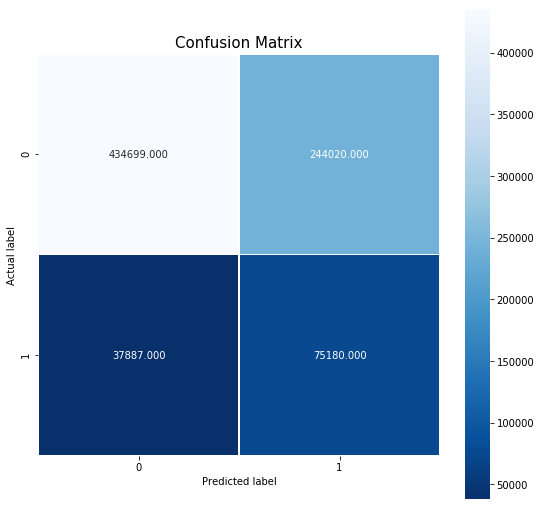

In [140]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix'
plt.title(all_sample_title, size = 15);

In [142]:
n_probs = [0 for _ in range(len(testSet))] # Naive predicted probabilities, all 0, which is the dominant class
lr_probs = clf.predict_proba(testSet) #Logistic Regression predicted probabilities

In [143]:
#clf.classes_
lr_probs = lr_probs[:, 1]
#Calculate and print auc score
n_auc = roc_auc_score(df_Ytest, n_probs)
lr_auc = roc_auc_score(df_Ytest, lr_probs)
print('Naive: ROC AUC=%.3f' % (n_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

Naive: ROC AUC=0.500
Logistic: ROC AUC=0.710



#RF for var select
#IV and WOE
